# Insurance Charges Prediction {-}

# Content {-}

* [1. Problem Definition](#1.-problem-definition)
* [2. Getting Started- Loading data and python packages](#2.-getting-started-loading-data-and-python-packages)
    * [2.1 Loading Python Packages](##2.1-loading-python-packages)
    * [2.2 Loading Data](##2.2-loading-data)
* [3. Exploratory Data Analysis](#3.-exploratory-data-analysis)
* [4. Data Preprocessing](#4.-data-preprocessing)
* [5. Model Building](#5.-model-building)
    * [5.1 K-fold cross validation for model selection](##5.1-k-fold-cross-validation-for-model-selection)
    * [5.2 Model Tuning](##5.2-model-tuning)
* [6. Evaluating Best Model on Test Data](#6.-evaluating-best-model-on-test-data)
    * [6.1. Results on the Test Set](##6.1.-results-on-the-test-set)
    * [6.2. Feature Importance](##6.2.-feature-importance)
* [7. Summary](#7.-summary)

# 1. Problem Definition {-}

Develop and compare multiple machine learning regression models to predict clients' insurance
charges:
1. Perform an EDA
2. Preprocess the data
3. Build the models
4. Explain the outputs

# 2. Getting Started - Loading data and python packages {-}

## 2.1 Loading Python Packages {-}

In [21]:
# import numpy as np
# import pygwalker as pyg
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score,
    GridSearchCV,
)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet

## 2.2 Loading Data {-}

In [22]:
df = pd.read_csv("insurance.csv")

In [23]:
df.shape

(1338, 7)

In [24]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# 3. Exploratory Data Analysis {-}

In [25]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [26]:
train_idx, test_idx = train_test_split(df.index, test_size=0.2, random_state=42)

In [27]:
print(train_idx.shape, test_idx.shape)

(1070,) (268,)


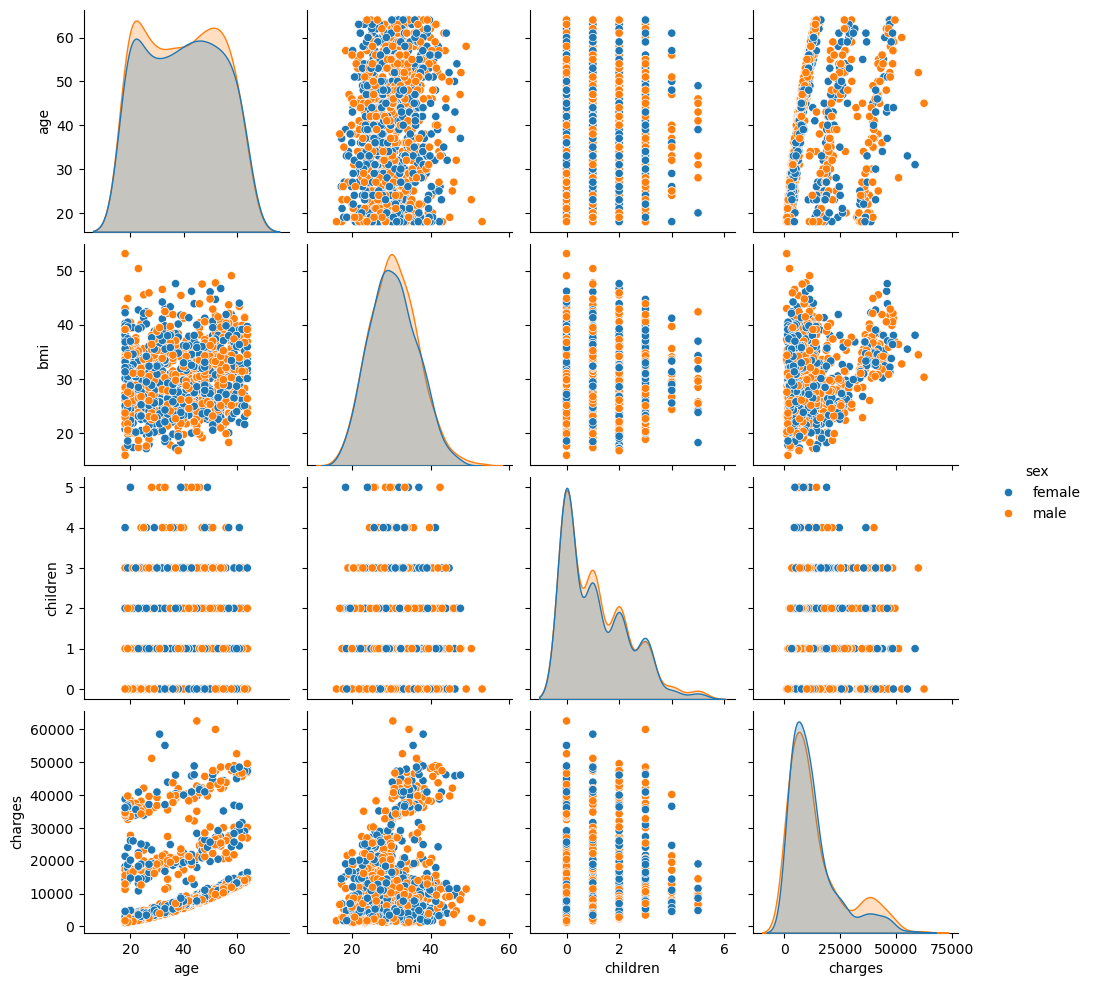

In [28]:
sns.pairplot(df.iloc[train_idx], hue="sex")
plt.show()

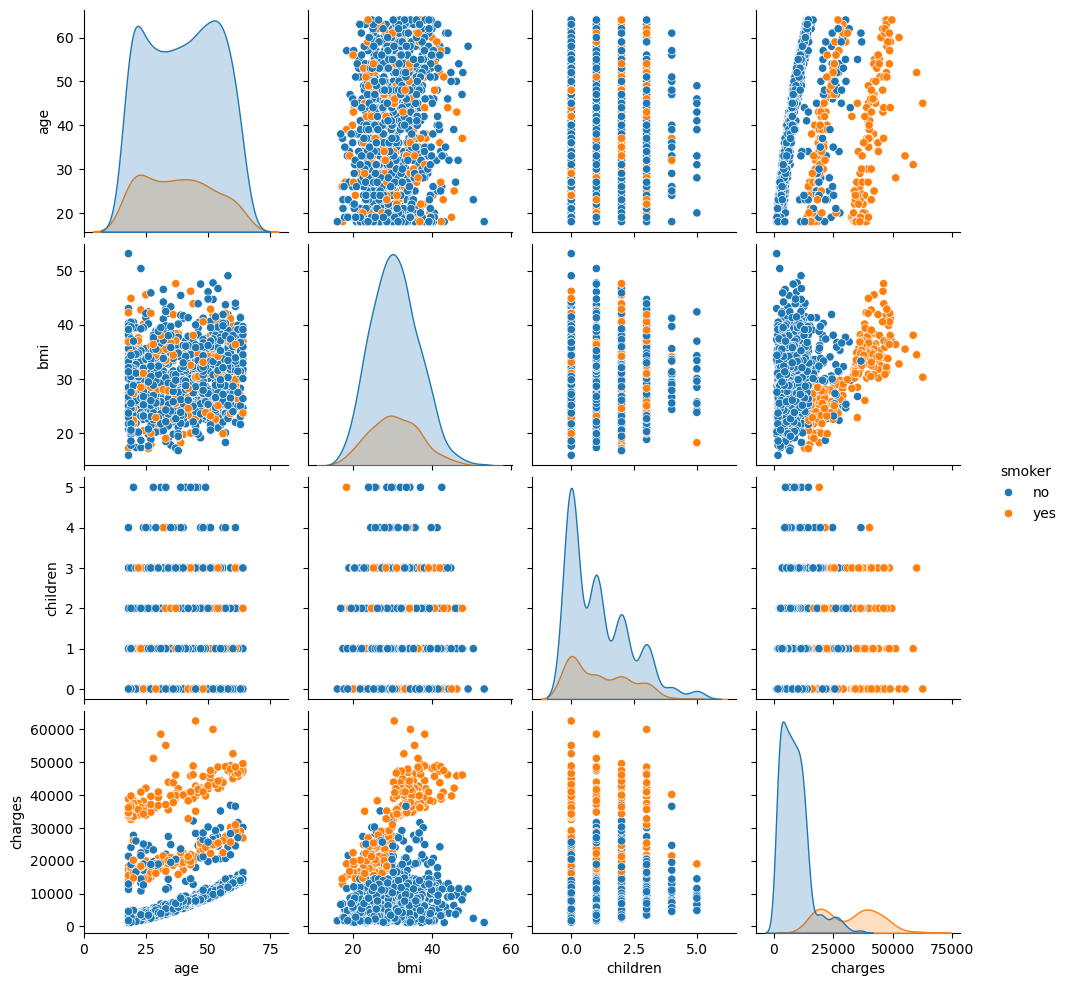

In [29]:
sns.pairplot(df.iloc[train_idx], hue="smoker")
plt.show()

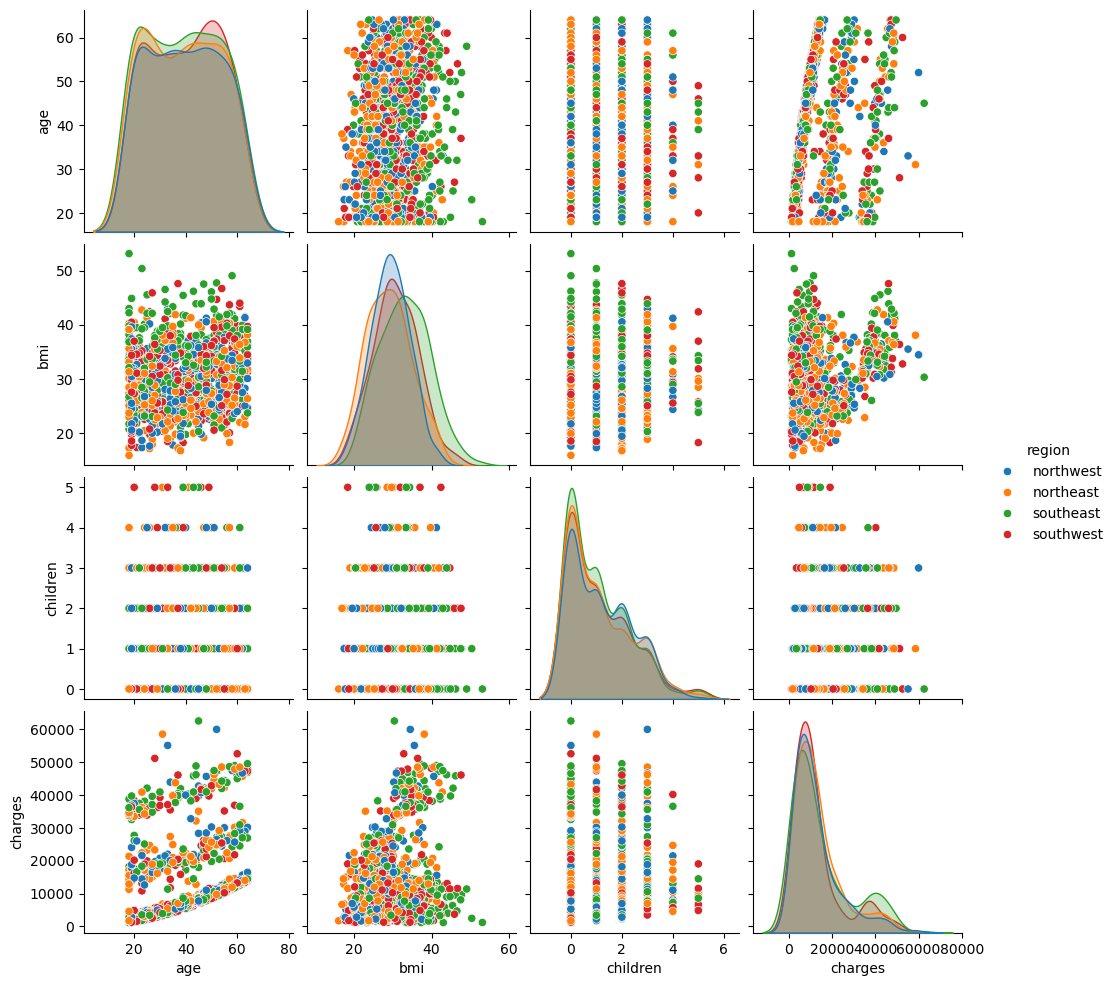

In [30]:
sns.pairplot(df.iloc[train_idx], hue="region")
plt.show()

We can observe from the three pair plots that amongst the catagorical variables `sex`, `smoker` & `region`, only `smoker` has a significant impact on the distribution of data.

To further investigate the correlation between the variables, we can use a heatmap.

In [31]:
data_full = pd.get_dummies(df)

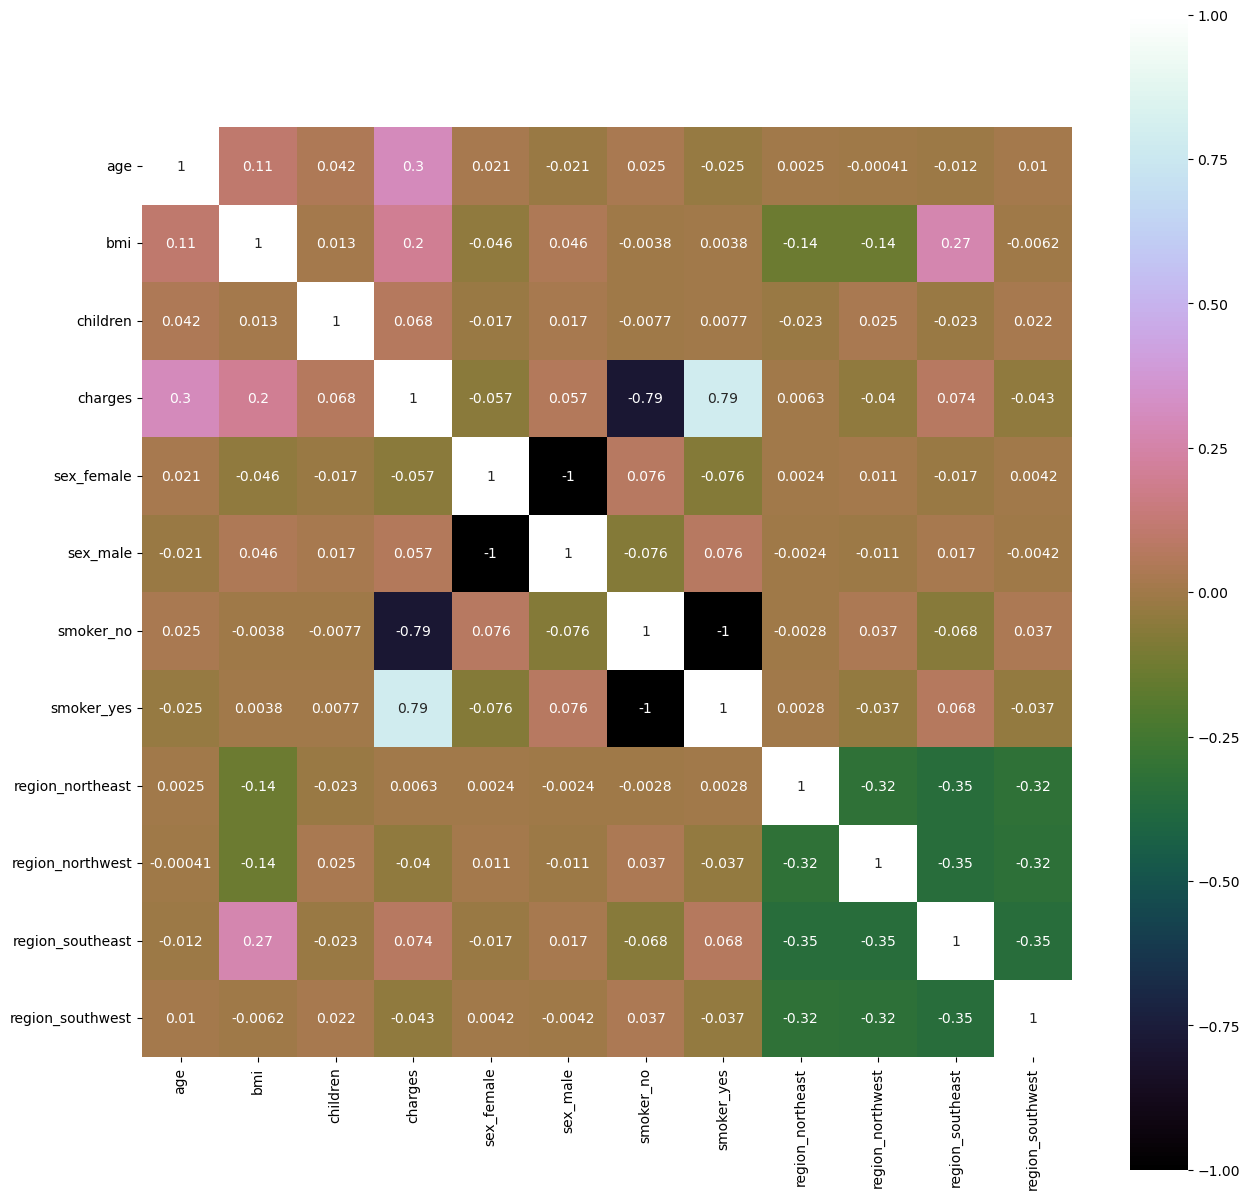

In [32]:
plt.figure(figsize=(15, 15))
sns.heatmap(data_full.corr(), annot=True, square=True, cmap='cubehelix')
plt.show()

As can be seen from the heatmap, the independent varibles with the highest correlation with the dependent variable `charges` is indeed `smoker`. Additionally, `age` and `bmi` turn out to have a reasonable correlation with `charges` as well.

Due to the existence of these variables with minimal correlation with `charges`, we will mainly explore the uses of tree-based models and regression models (with regularization) for prediction, as they are able to perform embedded feature selection.

# 4. Data Preprocessing {-}

* One-hot encoding is done at the end of the previous section.
* Data scaling is done on the fly using `StandardScaler` and `Pipeline` in sklean when doing cross validation below.

In [33]:
# Train test split done in part 3
data_train, data_test = data_full.iloc[train_idx], data_full.iloc[test_idx]

In [34]:
x_train = data_train.drop("charges", axis=1)
y_train = data_train["charges"]

x_test = data_test.drop("charges", axis=1)
y_test = data_test["charges"]

# 5. Model Building {-}

## 5.1 K-fold cross validation for model selection {-}

In [35]:
NUM_FOLDS = 10
SCORING = "r2"

In [36]:
models = []
models.append(('RandomForest', RandomForestRegressor()))
models.append(('GradientBoosting', GradientBoostingRegressor()))
models.append(('DecisionTree', DecisionTreeRegressor()))
models.append(('LinearRegression', LinearRegression()))
models.append(('Lasso', Lasso()))
models.append(('ElasticNet', ElasticNet()))

In [37]:
results = []

for name, model in models:
    kfold = KFold(n_splits=NUM_FOLDS, random_state=42, shuffle=True)
    # This applies the scaler to training data only at each cross-validation fold
    # Tree based models do not really need scaling, but it does not hurt :)
    pipeline = make_pipeline(StandardScaler(), model)
    cv_results = cross_val_score(pipeline, x_train, y_train, scoring=SCORING, cv=kfold)
    results.append(cv_results)
    print(f"{name}: mean={cv_results.mean()}, stdev={cv_results.std()}")

RandomForest: mean=0.828774107308966, stdev=0.030712548623081034
GradientBoosting: mean=0.8491661556232681, stdev=0.03995386454671507
DecisionTree: mean=0.7160840331052682, stdev=0.05045385236395765
LinearRegression: mean=0.7351269801709991, stdev=0.04324642888162463
Lasso: mean=0.7355980623753083, stdev=0.04399900675792285
ElasticNet: mean=0.6977030793693055, stdev=0.03876513897748103


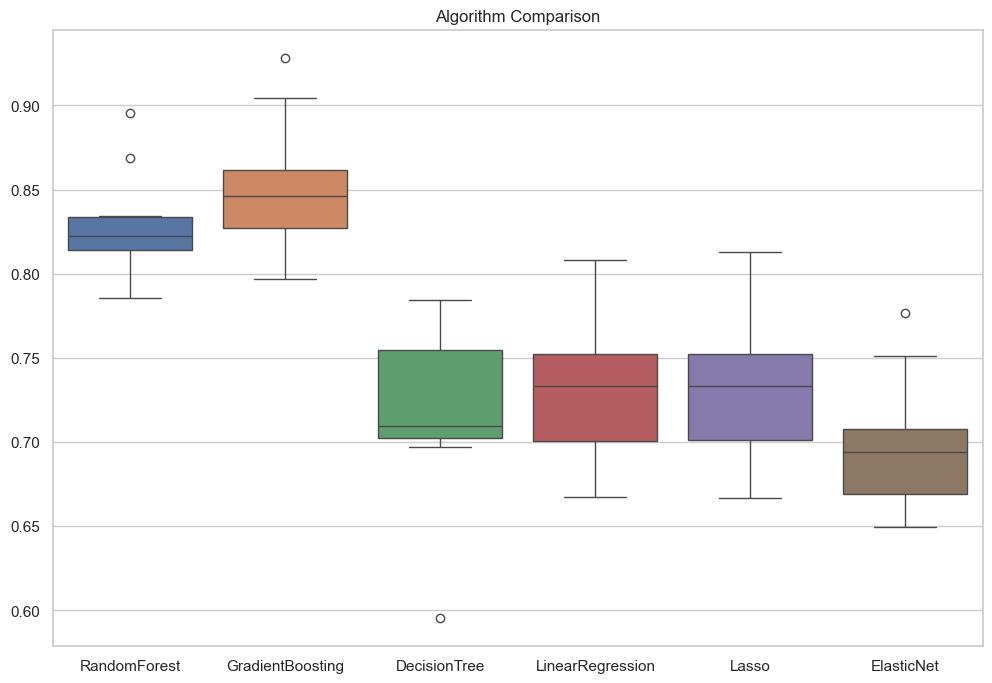

In [38]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))
plt.title("Algorithm Comparison")

sns.boxplot(data=results, formatter=lambda x: [name for name, _ in models][x])
plt.show()

Non-linear tree-based models performed better than linear regression models. Interestingly, elatsic net regression performed noticably worse than the other linear models. Perhaps more flexibility leads to overfitting in this case?

On the other hand, Gradient boosting is known to be resistant to overfitting, and it does seem to have the best overall performance (although Random Forest is close). We will use it for further hyperparameter tuning.

## 5.2 Model Tuning {-}

In [39]:
param_grid = {
    "learning_rate": [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
    "n_estimators": [100, 150, 200, 250, 300, 400, 500],
    # "max_depth": [3, 5, 7, 9, 11, 13],
    "max_features": ["sqrt", "log2", None],
    # "min_samples_split": [2, 4, 6, 8, 10],
    # "min_samples_leaf": [1, 2, 3, 4, 5],
}

In [40]:
kfold = KFold(n_splits=NUM_FOLDS, random_state=42, shuffle=True)
pipeline = make_pipeline(StandardScaler(), GradientBoostingRegressor())
grid_search = GridSearchCV(
    GradientBoostingRegressor(), param_grid, scoring=SCORING, cv=kfold
)
grid_result = grid_search.fit(x_train, y_train)
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
# for mean, stdev, param in zip(means, stds, params):
#     print(f"mean={mean}, stdev={stdev} with parameters {param}")

Best: 0.855023032954841 using {'learning_rate': 0.05, 'max_features': None, 'n_estimators': 100}


In [41]:
le = LabelEncoder()
color_map = le.fit_transform(grid_result.cv_results_["param_max_features"])
max_features_types = ["sqrt", "log2", None]

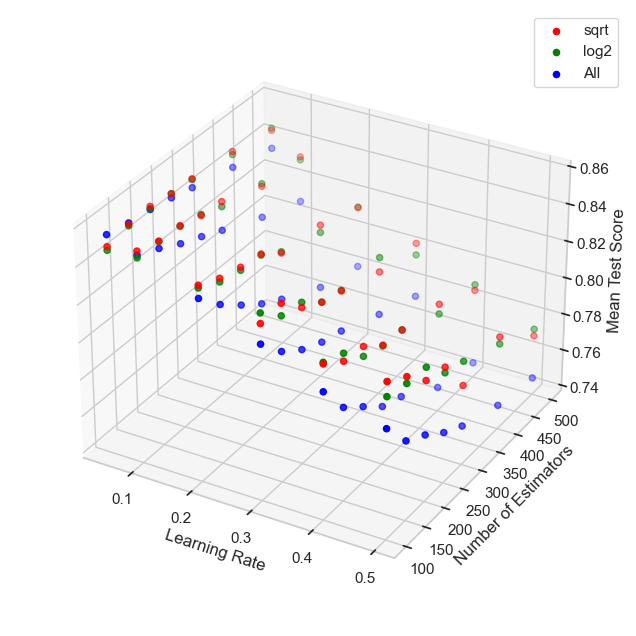

In [42]:
fig = plt.figure(figsize=(12, 8), constrained_layout=False)
ax = fig.add_subplot(111, projection="3d")

for i, category in enumerate(max_features_types):
    mask = grid_result.cv_results_["param_max_features"] == category
    ax.scatter(
        grid_result.cv_results_["param_learning_rate"][mask],
        grid_result.cv_results_["param_n_estimators"][mask],
        grid_result.cv_results_["mean_test_score"][mask],
        color=["red", "green", "blue"][i],
        label=category if category else "All"
    )
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Number of Estimators')
ax.set_zlabel('Mean Test Score')
ax.set_box_aspect(aspect=None, zoom=0.9)
ax.legend()
plt.show()

It can be observed that amongst the three hyperparameters we used for tuning, `learning_rate` has the most significant impact on the performance of the model, with lower rates leading to definitevely better results.

`n_estimators` also has a less significant, but still noticable impact, with lower values leading to slightly better results.

At last, the effect of `max_features`, which is the number of features to consider when looking for the best split at each level, appears to have no meaningful impact on the performance of the model.

However, it is worth noting when the other two hyperparameters are set to suboptimal values, the "all" option of "max_feature" (blue dots in the plot) can apparently lead to a significant drop in model performance when compared to the other two options ("sqrt" and "log2"). One possible explanation for this is that the "all" option can exacerbate overfitting problems when the other hyperparameters are not set to optimal values.

# 6. Evaluating Best Model on Test Data {-}

## 6.1. Results on the Test Set {-}

In [43]:
print("Best parameter combination ('max_features': None means max_features=n_features):")
print(grid_result.best_params_)

Best parameter combination ('max_features': None means max_features=n_features):
{'learning_rate': 0.05, 'max_features': None, 'n_estimators': 100}


In [44]:
best_model = GradientBoostingRegressor(
    learning_rate=grid_result.best_params_["learning_rate"],
    n_estimators=grid_result.best_params_["n_estimators"],
    max_features=grid_result.best_params_["max_features"],
)

best_model.fit(x_train, y_train)
train_predictions = best_model.predict(x_train)
test_predictions = best_model.predict(x_test)
print(f"Training set R2: {r2_score(y_train, train_predictions)}")
print(f"Training set MSE: {mean_squared_error(y_train, train_predictions)}")
print(f"Test set R2: {r2_score(y_test, test_predictions)}")
print(f"Test set MSE: {mean_squared_error(y_test, test_predictions)}")

Training set R2: 0.881811756649547
Training set MSE: 17058537.23268715
Test set R2: 0.8807314429342721
Test set MSE: 18516292.19130845


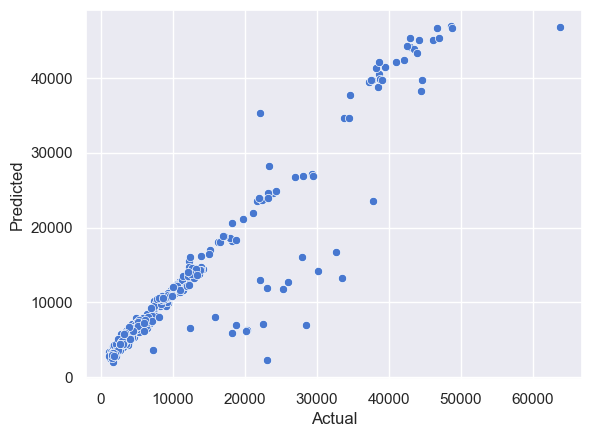

In [45]:
sns.set_theme(palette="muted")
sns.scatterplot(x=y_test, y=test_predictions)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

From the MSE and R2 scores of the best model we selected, we can see that the performance on testing data is quite similar to that on the training data, which shows our model has low variance and good generalization ability.

From the actual vs predicted plot, we can see that the model is indeed doing a good job at predicting the charges, with the predicted values being quite close to the actual values in all but a few outlier cases.

## 6.2. Feature Importance {-}

Feature importances: [1.16668712e-01 1.81551696e-01 8.26285756e-03 3.07700455e-04
 7.97597165e-05 5.26270778e-01 1.63693184e-01 1.22356091e-03
 7.59442750e-04 1.55582788e-04 1.02672578e-03]


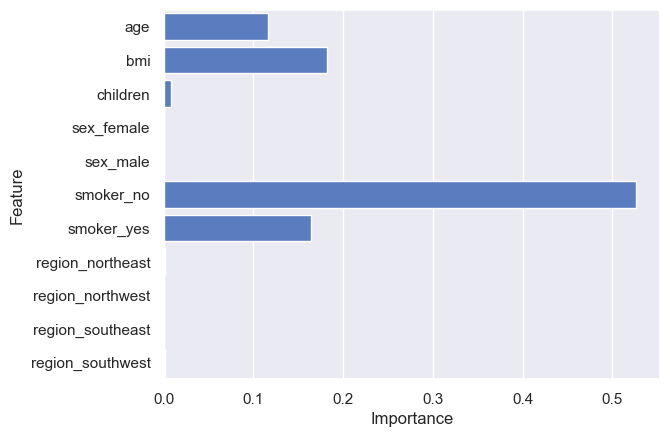

In [46]:
print(f"Feature importances: {best_model.feature_importances_}")
sns.barplot(x=best_model.feature_importances_, y=x_train.columns, orient="h")
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

The feature importance result perfectly aligns with the analyses conducted in the EDA section. The most important feature is indeed `smoker`, followed by `age` and `bmi`. In comparison, the other features do have almost negligible performance impacts.

# 7. Summary {-}

We showed that machine learning models can be use to effectively predict insurance charges based on the given variables. What's more, tree-based models such as Gradient Boosting and Random Forest apparently did a better job at capturing the non-linear relationships in the data, and thus performed better than regression models.

Specifically for tree-based models, we also demonstrated that effecacy of their embedded parameter selection power by showing that the features selected by our model precisely aligned with the feature importance analysis we conducted in the EDA section at the beginning.